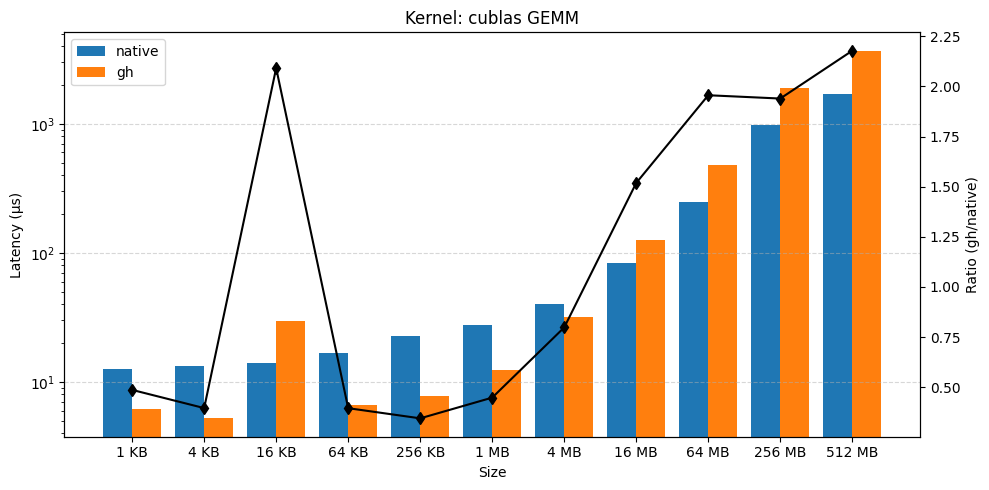

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSVs (two columns: size in bytes, latency in µs; no header)
native = pd.read_csv("./results/native.csv", header=None, names=["size", "lat"])
gh = pd.read_csv("./results/gh.csv", header=None, names=["size", "lat"])

# Collect all unique sizes
sizes = np.unique(np.concatenate([native["size"].values, gh["size"].values]))
sizes.sort()

# Merge into dict for quick lookup
native_dict = dict(zip(native["size"], native["lat"]))
gh_dict = dict(zip(gh["size"], gh["lat"]))

native_vals = [native_dict.get(s, np.nan) for s in sizes]
gh_vals = [gh_dict.get(s, np.nan) for s in sizes]

# Formatter for size ticks
MiB, KiB = 1024 * 1024, 1024
def fmt_size(x):
    if x < MiB:
        return f"{int(round(x / KiB))} KB"
    mb = x / MiB
    return f"{int(mb)} MB" if abs(mb - round(mb)) < 1e-9 else f"{mb:.1f} MB"

# Bar chart parameters
x = np.arange(len(sizes))
bar_w = 0.4

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - bar_w/2, native_vals, width=bar_w, label="native")
ax.bar(x + bar_w/2, gh_vals, width=bar_w, label="gh")

ax.set_xlabel("Size")
ax.set_ylabel("Latency (µs)")
ax.set_xticks(x)
# ax.set_xticklabels([fmt_size(s) for s in sizes], rotation=45, ha="right")
ax.set_xticklabels([fmt_size(s) for s in sizes])
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_yscale("log")
ax.set_title("Kernel: cublas GEMM")

ax2 = ax.twinx(); ax2.plot(x, np.array(gh_vals)/np.array(native_vals), marker="d", color="black", label="gh/native"); ax2.set_ylabel("Ratio (gh/native)")


fig.tight_layout()
plt.show()


# C2C traffic

In [14]:
#!/usr/bin/env python3
import os
import re
import glob
import math
import pandas as pd

PROFILE_DIR = "./profile"   # folder containing gh_{size}.csv files
FILE_GLOB   = os.path.join(PROFILE_DIR, "gh_*.csv")  # filename pattern

def parse_size_from_filename(path):
    # Expect filenames like: gh_{size}.csv  (size in bytes, digits only)
    m = re.search(r"gh_(\d+)\.csv$", os.path.basename(path))
    return int(m.group(1)) if m else None

def to_bytes(val, unit):
    """Convert Metric Value + Metric Unit into bytes."""
    if pd.isna(val):
        return 0
    try:
        v = float(val)
    except Exception:
        v = 0.0

    u = (unit or "").strip().lower()
    # normalize common variants
    if "gbyte" in u or u == "gb" or "gbytes" in u:
        return int(v * (1024**3))
    if "mbyte" in u or u == "mb" or "mbytes" in u:
        return int(v * (1024**2))
    if "kbyte" in u or u == "kb" or "kbytes" in u:
        return int(v * 1024)
    # treat anything else (including "byte", "bytes", "", unknown) as raw bytes
    return int(v)

def aggregate_file(path):
    """Return (size_in_bytes, group_df, avg_bytes) for a single CSV file."""
    size = parse_size_from_filename(path)
    df = pd.read_csv(path)

    # Filter Metric Name == "Received User Bytes"
    df = df[df["Metric Name"] == "Received User Bytes"].copy()
    if df.empty:
        group_df = pd.DataFrame(columns=["group_id", "Received User Bytes (bytes)"])
        return size, group_df, 0

    # Convert Metric Value + Unit => bytes
    df["Metric Bytes"] = [
        to_bytes(v, u) for v, u in zip(df["Metric Value"], df["Metric Unit"])
    ]

    num_rows = len(df)
    num_functions = max(1, num_rows // 15)   # <= your corrected rule
    group_size = num_functions               # aggregate every num_functions rows

    # chunk sequentially by group_size
    grouped_rows = []
    gid = 0
    for start in range(0, num_rows, group_size):
        end = min(start + group_size, num_rows)
        group_sum = int(df["Metric Bytes"].iloc[start:end].sum())
        grouped_rows.append((gid, group_sum))
        gid += 1

    group_df = pd.DataFrame(grouped_rows, columns=["group_id", "Received User Bytes (bytes)"])
    avg_bytes = int(group_df["Received User Bytes (bytes)"].mean()) if not group_df.empty else 0
    return size, group_df, avg_bytes

paths = sorted(glob.glob(FILE_GLOB))
if not paths:
    print(f"No files matched {FILE_GLOB}")
else:

    final_rows = []
    for p in paths:
        size, group_df, avg_bytes = aggregate_file(p)
        # if size !=536870912:
        #     continue
        fname = os.path.basename(p)
        # print(f"\nTable for {fname} (size={size}):")
        # if group_df.empty:
        #     print("  (no rows with Metric Name = 'Received User Bytes')")
        # else:
        #     print(group_df.to_string(index=False))

        print(f"Average across groups for {fname}: {int(avg_bytes)} bytes")
        if size is not None:
            final_rows.append((size, int(avg_bytes)))

    if final_rows:
        final_df = pd.DataFrame(final_rows, columns=["Buffer Size", "C2C Traffic"]).sort_values("Buffer Size")
        print("\nFinal Aggregated Table across files:")
        print(final_df.to_string(index=False))
    else:
        print("\nFinal Aggregated Table across files:\n  (no data)")




Average across groups for gh_1024.csv: 3356 bytes
Average across groups for gh_1048576.csv: 1375032 bytes
Average across groups for gh_16384.csv: 13142 bytes
Average across groups for gh_16777216.csv: 25587351 bytes
Average across groups for gh_262144.csv: 263263 bytes
Average across groups for gh_268435456.csv: 379902579 bytes
Average across groups for gh_4096.csv: 5172 bytes
Average across groups for gh_4194304.csv: 5505024 bytes
Average across groups for gh_536870912.csv: 806072808 bytes
Average across groups for gh_65536.csv: 25865 bytes
Average across groups for gh_67108864.csv: 101886634 bytes

Final Aggregated Table across files:
 Buffer Size  C2C Traffic
        1024         3356
        4096         5172
       16384        13142
       65536        25865
      262144       263263
     1048576      1375032
     4194304      5505024
    16777216     25587351
    67108864    101886634
   268435456    379902579
   536870912    806072808
